In [7]:
import os
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image


In [8]:
ROOT_DIR = "dataset/fruit360"
TEST_DIR = os.path.join(ROOT_DIR, "Test")

class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            label = class_name if self.variety else class_name.split()[0]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.png')):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for i, lbl in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label_str

SIZE = 32
transform_32 = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

test_dataset_32 = Fruit360FolderDataset(TEST_DIR, transform=transform_32, variety=False)

BATCH_SIZE = 100
test_loader_32 = DataLoader(test_dataset_32, batch_size=BATCH_SIZE, shuffle=False)
print(f"Test loader 32x32: {len(test_dataset_32)} images, {len(test_loader_32)} batches")


Test: 43442 images, 79 classes
Test loader 32x32: 43442 images, 435 batches


In [9]:
import math

def clamp_01(x):
    return torch.clamp(x, 0.0, 1.0)

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area / r))
        patch_w = int(math.sqrt(patch_area * r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp_01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area / r))
    patch_w = int(math.sqrt(patch_area * r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp_01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

def noise_mild(x):
    return clamp_01(x + torch.randn_like(x) * 0.025)

def dark_mild(x):
    return clamp_01(x * 0.65)

def overexposed_mild(x):
    return clamp_01(x * 1.35)

def dirty_mild(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))

def bruised_mild(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))

def occlusion_small(x):
    return add_occlusion_patch(x, area_ratio=0.10, alpha=0.5)

blur_medium = T.GaussianBlur(kernel_size=5, sigma=1.0)

def scenario_A(x):
    x = blur_medium(x)
    x = noise_mild(x)
    if np.random.rand() < 0.7:
        x = dirty_mild(x)
    return x

def scenario_B(x):
    if np.random.rand() < 0.5:
        x = dark_mild(x)
    else:
        x = overexposed_mild(x)
    x = noise_mild(x)
    return x

def scenario_C(x):
    x = occlusion_small(x)
    if np.random.rand() < 0.5:
        x = bruised_mild(x)
    else:
        x = dirty_mild(x)
    return x

scenario_fns = {
    "scenario_A": scenario_A,
    "scenario_B": scenario_B,
    "scenario_C": scenario_C,
}
print(list(scenario_fns.keys()))


['scenario_A', 'scenario_B', 'scenario_C']


In [10]:
import joblib

device = torch.device("cpu")

scaler_32 = joblib.load("saved_models/scaler_32x32.joblib")
pca_32 = joblib.load("saved_models/pca_32x32.joblib")
svm_32 = joblib.load("saved_models/svm_32x32.joblib")

print("Loaded scaler_32, pca_32, svm_32 from saved_models/")


Loaded scaler_32, pca_32, svm_32 from saved_models/


In [11]:
def evaluate_scenario_32(test_loader, scenario_fn):
    all_preds = []
    all_labels = []
    start = time.time()
    
    for imgs, labels_str in test_loader:
        imgs_scn = []
        for img in imgs:
            x = scenario_fn(img)
            imgs_scn.append(x.unsqueeze(0))
        imgs_scn = torch.cat(imgs_scn, dim=0)
        
        X = imgs_scn.numpy()
        X = X.reshape(X.shape[0], -1)
        X = scaler_32.transform(X)
        X = pca_32.transform(X)
        preds = svm_32.predict(X)
        
        all_preds.extend(preds)
        all_labels.extend(labels_str)
    
    all_preds = np.array(all_preds)
    label_indices = np.array([test_dataset_32.label_to_idx[l] for l in all_labels])
    acc = (all_preds == label_indices).mean()
    elapsed = time.time() - start
    return acc, elapsed


In [13]:
import pandas as pd

results_scenarios = []

for name, fn in scenario_fns.items():
    print(f"\nTesting 32x32 on {name}...")
    acc, tsec = evaluate_scenario_32(test_loader_32, fn)
    print(f"Accuracy: {acc:.4f} | Time: {tsec:.2f}s")
    results_scenarios.append({
        "model_name": "32x32",
        "model_size": 32,
        "scenario": name,
        "accuracy": acc,
        "test_time_sec": tsec,
    })

results_scenarios_df = pd.DataFrame(results_scenarios)
results_scenarios_df



Testing 32x32 on scenario_A...
Accuracy: 0.2953 | Time: 373.60s

Testing 32x32 on scenario_B...
Accuracy: 0.1886 | Time: 369.59s

Testing 32x32 on scenario_C...
Accuracy: 0.7866 | Time: 365.13s


,model_name,model_size,scenario,accuracy,test_time_sec
0,32x32,32,scenario_A,0.295336,373.598497
1,32x32,32,scenario_B,0.188642,369.589995
2,32x32,32,scenario_C,0.786635,365.131163


In [14]:
robust_global = pd.read_csv("results/robustness_global.csv")

mask_32 = robust_global["model_name"] == "32x32"
cols_keep = ["model_name", "model_size", "degradation", "accuracy"]

main_degradations = ["clean", "blur_medium", "noise_medium", "dark", "overexposed", "dirty", "bruised", "occlusion"]

robust_32_main = robust_global[mask_32 & robust_global["degradation"].isin(main_degradations)][cols_keep]
robust_32_main = robust_32_main.sort_values("degradation").reset_index(drop=True)
robust_32_main


,model_name,model_size,degradation,accuracy
0,32x32,32,blur_medium,0.881037
1,32x32,32,bruised,0.779798
2,32x32,32,clean,0.974242
3,32x32,32,dark,0.094079
4,32x32,32,dirty,0.713940
5,32x32,32,noise_medium,0.094632
6,32x32,32,occlusion,0.827310
7,32x32,32,overexposed,0.296050


In [15]:
scenarios_for_merge = results_scenarios_df.copy()
scenarios_for_merge = scenarios_for_merge.rename(columns={"scenario": "degradation"})
scenarios_for_merge = scenarios_for_merge[["model_name", "model_size", "degradation", "accuracy"]]

table_32_full = pd.concat([robust_32_main, scenarios_for_merge], ignore_index=True)
table_32_full = table_32_full.sort_values("degradation").reset_index(drop=True)

table_32_full


,model_name,model_size,degradation,accuracy
0,32x32,32,blur_medium,0.881037
1,32x32,32,bruised,0.779798
2,32x32,32,clean,0.974242
3,32x32,32,dark,0.094079
4,32x32,32,dirty,0.713940
5,32x32,32,noise_medium,0.094632
6,32x32,32,occlusion,0.827310
7,32x32,32,overexposed,0.296050
8,32x32,32,scenario_A,0.295336
9,32x32,32,scenario_B,0.188642


In [18]:
table_32_pretty = table_32_full[["degradation", "accuracy"]].set_index("degradation").sort_index()
table_32_pretty
table_32_pretty_rounded = table_32_pretty.round(4)
table_32_pretty_rounded

,accuracy
degradation,
blur_medium,0.8810
bruised,0.7798
clean,0.9742
dark,0.0941
dirty,0.7139
noise_medium,0.0946
occlusion,0.8273
overexposed,0.2960
scenario_A,0.2953


In [19]:
single_mask = table_32_full["degradation"].isin(main_degradations)
scenario_mask = table_32_full["degradation"].str.startswith("scenario_")

single_acc = table_32_full[single_mask]["accuracy"]
scenario_acc = table_32_full[scenario_mask]["accuracy"]

summary_dict = {
    "single_mean_acc": single_acc.mean(),
    "single_min_acc": single_acc.min(),
    "single_max_acc": single_acc.max(),
    "scenario_mean_acc": scenario_acc.mean(),
    "scenario_min_acc": scenario_acc.min(),
    "scenario_max_acc": scenario_acc.max(),
}

summary_df = pd.DataFrame.from_dict(summary_dict, orient="index", columns=["value"])
summary_df


,value
single_mean_acc,0.582636
single_min_acc,0.094079
single_max_acc,0.974242
scenario_mean_acc,0.423538
scenario_min_acc,0.188642
scenario_max_acc,0.786635


<Figure size 1000x400 with 0 Axes>

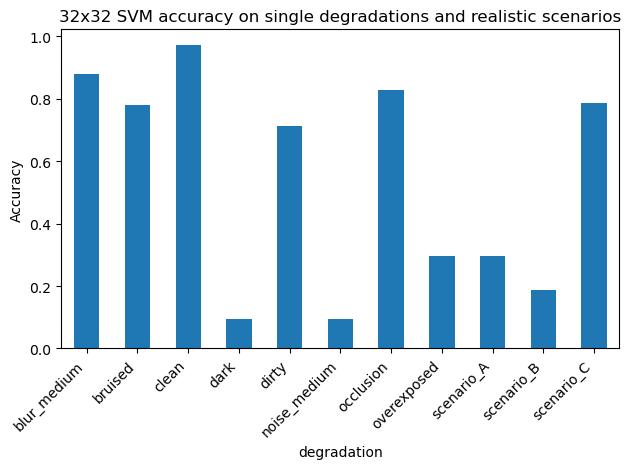

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
table_32_pretty.plot(kind="bar", legend=False)
plt.ylabel("Accuracy")
plt.title("32x32 SVM accuracy on single degradations and realistic scenarios")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
